### Modelling and Overall Interpretation of Results

Overall Research Questions:
1) How do customers define 'good' service, and how does the new script shift those definitions?
2) What aspects of service (clarity, empathy, agent personality) drive variance in sentiment?
3) Does the new script systematically change perceptions or emotional tone, particularly for high-value segments like VOLT?


#### Topic Analysis
For each group (general/VOLT), answer:
- What are the top latent topics mentioned?
- How do topic distributions differ by treatment?
- What percentage of comments mention agent personality, clarity or reassurance?

#### Sentiment Analysis
- Compare:
    - Sentiment distribution between treatment vs. control
    - Strength of sentiment for VOLT vs. general sample
- What topics co-occur with negative or positive sentiment?
- Are there any shift in emotional tone driven by the new script?

#### Modelling + Interpretation

- Train a classification model to predict positive vs. negative sentiment using extracted topics of LLM embeddings
    - Identify key explainers of sentiment
- Evaluate whether treatment assignment is predictive of topic use or sentiment, controlling for segment


##### Firstly let's breakdown our whole data, which has topic and sentiment information

In [94]:
# Enhanced imports for presentation-quality visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
import re
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set consistent styling for all plots
plt.style.use('default')
sns.set_palette("Set2")

# Define consistent color scheme
COLORS = {
    'control': '#1f77b4',      # Blue
    'treatment': '#ff7f0e',    # Orange  
    'general': '#2ca02c',      # Green
    'volt': '#d62728',         # Red
    'positive': '#2ca02c',     # Green
    'negative': '#d62728',     # Red
    'neutral': '#9467bd'       # Purple
}

# Load and inspect data
df = pd.read_pickle("../data/processed/data_with_sentiment_and_topics.pkl")

# Create readable segment labels
df = df.copy()
df["SEGMENT"] = df["VOLT_FLAG_BINARY"].map({0: "General", 1: "VOLT"}).fillna("General")
df["TREATMENT"] = df["TREATMENT_BINARY"].map({0: "Control", 1: "Treatment"})

print("📊 DATASET OVERVIEW")
print("="*50)
print(f"Total comments: {len(df):,}")
print(f"Comments with sentiment: {df['SENTIMENT_SCORE'].notna().sum():,}")
print(f"Treatment split: {df['TREATMENT'].value_counts().to_dict()}")
print(f"Segment split: {df['SEGMENT'].value_counts().to_dict()}")

print(f"\n📈 SENTIMENT & MAGNITUDE RANGES:")
print(f"Sentiment Score: {df['SENTIMENT_SCORE'].min():.2f} to {df['SENTIMENT_SCORE'].max():.2f}")
print(f"Magnitude Score: {df['SENTIMENT_MAGNITUDE'].min():.2f} to {df['SENTIMENT_MAGNITUDE'].max():.2f}")

# Topic overview
all_topics = [topic for sublist in df['substantive_topics'] for topic in sublist]
unique_topics = set(all_topics)
print(f"\n🎯 TOPICS IDENTIFIED: {len(unique_topics)} unique substantive topics")

# Quick data quality check
comment_coverage = df['LTR_COMMENT_CLEAN'].notna().sum() / len(df)
sentiment_coverage = df['SENTIMENT_SCORE'].notna().sum() / len(df)
print(f"\n✅ DATA QUALITY:")
print(f"Comment coverage: {comment_coverage:.1%}")
print(f"Sentiment coverage: {sentiment_coverage:.1%}")


📊 DATASET OVERVIEW
Total comments: 582
Comments with sentiment: 428
Treatment split: {'Control': 335, 'Treatment': 247}
Segment split: {'General': 341, 'VOLT': 241}

📈 SENTIMENT & MAGNITUDE RANGES:
Sentiment Score: -0.90 to 0.90
Magnitude Score: 0.00 to 6.30

🎯 TOPICS IDENTIFIED: 14 unique substantive topics

✅ DATA QUALITY:
Comment coverage: 73.5%
Sentiment coverage: 73.5%


## 🎯 Topic Analysis: Understanding Customer Concerns

**Research Questions:**
- What are the top topics mentioned across segments?
- How do topic distributions differ by treatment?
- What percentage of comments mention service quality themes (agent personality, clarity, reassurance)?

In [95]:
# ========================================================================
# 📊 COMPREHENSIVE TOPIC ANALYSIS
# ========================================================================

# Convenience masks for analysis
is_volt = df["VOLT_FLAG_BINARY"] == 1
is_gen = df["VOLT_FLAG_BINARY"] == 0
is_treat = df["TREATMENT_BINARY"] == 1
is_ctrl = df["TREATMENT_BINARY"] == 0

def enhanced_topic_analysis(df_subset, name, k=10):
    """Enhanced topic analysis with percentage calculations"""
    all_topics = Counter(t for row in df_subset["substantive_topics"] for t in row)
    total_comments = len(df_subset)
    
    top_k = all_topics.most_common(k)
    result = pd.DataFrame(top_k, columns=["topic", "mentions"])
    result["pct_comments"] = (result["mentions"] / total_comments * 100).round(1)
    result["subset"] = name
    return result

print("🔍 TOP TOPICS BY SEGMENT & TREATMENT")
print("="*60)

# Generate comprehensive topic breakdowns
topic_results = []
for segment, mask, color in [("General", is_gen, COLORS['general']), ("VOLT", is_volt, COLORS['volt'])]:
    for treatment, treat_mask, treat_color in [("Control", is_ctrl, COLORS['control']), ("Treatment", is_treat, COLORS['treatment'])]:
        combined_mask = mask & treat_mask
        if combined_mask.sum() > 0:  # Only if we have data
            result = enhanced_topic_analysis(df[combined_mask], f"{segment}_{treatment}", k=8)
            topic_results.append(result)

# Combine all results
all_topic_results = pd.concat(topic_results, ignore_index=True)

# Overall topic frequency for ranking
overall_topics = enhanced_topic_analysis(df, "Overall", k=15)
print("\n📈 OVERALL TOP TOPICS:")
print(overall_topics[['topic', 'mentions', 'pct_comments']].to_string(index=False))



🔍 TOP TOPICS BY SEGMENT & TREATMENT

📈 OVERALL TOP TOPICS:
                                    topic  mentions  pct_comments
      Staff Helpfulness and Communication        75          12.9
           Professional Service Standards        63          10.8
         Overall Customer Service Quality        37           6.4
      Sales Agent Performance and Process        33           5.7
 Contract Issues and Call Center Problems        33           5.7
   Service Delivery and Scheduling Issues        29           5.0
     Phone Support and Account Management        26           4.5
       Service Speed and Network Coverage        26           4.5
               Field Engineer Performance        23           4.0
            Pricing and Value Proposition        22           3.8
       Broadband Service and Connectivity        21           3.6
Installation Process and Setup Experience        21           3.6
 Installation Quality and Recommendations        15           2.6
             Comp

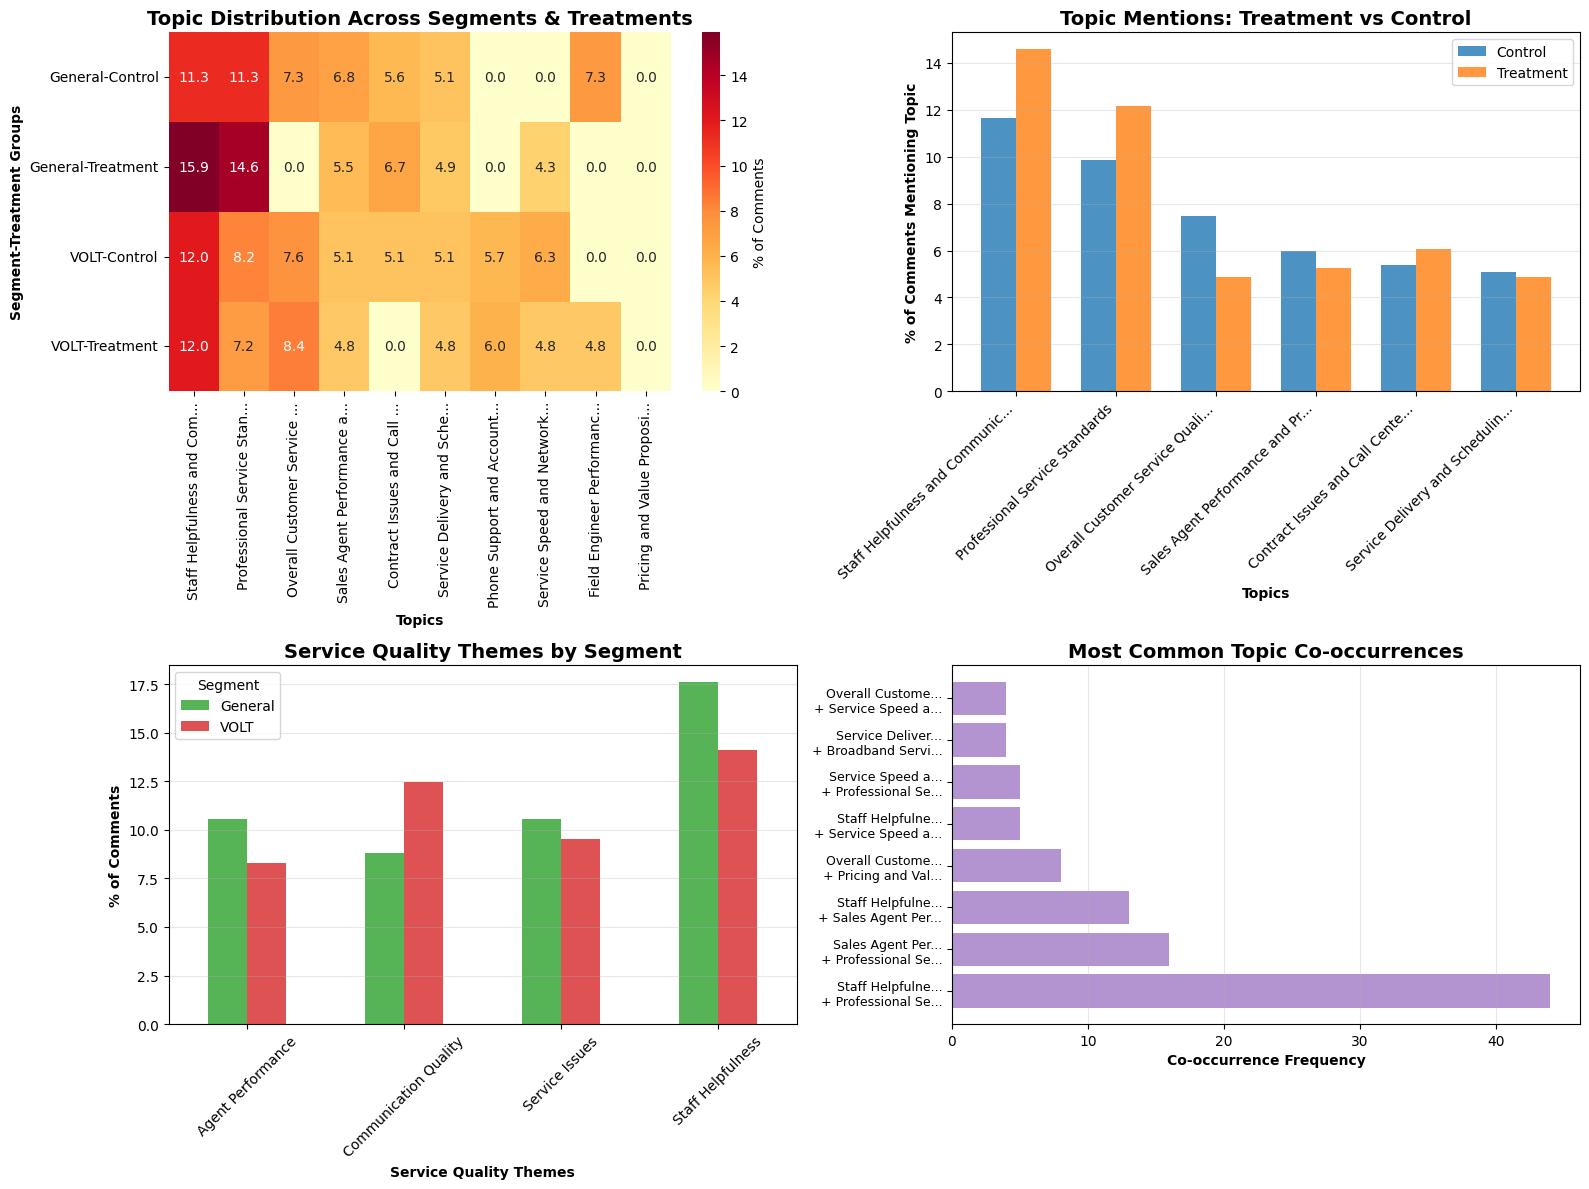


🎯 KEY TOPIC INSIGHTS
1. Top 3 topics overall: Staff Helpfulness and Communication, Professional Service Standards, Overall Customer Service Quality
2. Service quality themes coverage:
   • Staff Helpfulness: 15.9% of comments
   • Communication Quality: 10.6% of comments
   • Service Issues: 10.1% of comments
   • Agent Performance: 9.4% of comments
3. Most significant treatment differences:
   • Staff Helpfulness and Communic...: +2.9pp in treatment
   • Professional Service Standards: +2.3pp in treatment
   • Contract Issues and Call Cente...: +0.7pp in treatment


In [96]:
# ========================================================================
# 📈 PRESENTATION-READY TOPIC VISUALIZATIONS
# ========================================================================

# 1. Topic Distribution Heatmap by Segment
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for heatmap - top 10 topics overall
top_10_topics = overall_topics.head(10)['topic'].tolist()

# Create matrix for heatmap
heatmap_data = []
for segment in ['General', 'VOLT']:
    for treatment in ['Control', 'Treatment']:
        subset_name = f"{segment}_{treatment}"
        subset_data = all_topic_results[all_topic_results['subset'] == subset_name]
        row = []
        for topic in top_10_topics:
            topic_row = subset_data[subset_data['topic'] == topic]
            pct = topic_row['pct_comments'].iloc[0] if len(topic_row) > 0 else 0
            row.append(pct)
        heatmap_data.append(row)

heatmap_df = pd.DataFrame(
    heatmap_data, 
    columns=[t[:25] + '...' if len(t) > 25 else t for t in top_10_topics],
    index=['General-Control', 'General-Treatment', 'VOLT-Control', 'VOLT-Treatment']
)

# Plot heatmap
sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax1, cbar_kws={'label': '% of Comments'})
ax1.set_title('Topic Distribution Across Segments & Treatments', fontsize=14, fontweight='bold')
ax1.set_xlabel('Topics', fontweight='bold')
ax1.set_ylabel('Segment-Treatment Groups', fontweight='bold')

# 2. Treatment Comparison for Top Topics
treatment_comparison = []
for topic in top_10_topics[:6]:  # Top 6 for readability
    topic_data = df[df['substantive_topics'].apply(lambda x: topic in x)]
    if len(topic_data) > 0:
        ctrl_pct = (topic_data['TREATMENT_BINARY'] == 0).sum() / (df['TREATMENT_BINARY'] == 0).sum() * 100
        treat_pct = (topic_data['TREATMENT_BINARY'] == 1).sum() / (df['TREATMENT_BINARY'] == 1).sum() * 100
        treatment_comparison.append({
            'topic': topic[:30] + '...' if len(topic) > 30 else topic,
            'Control': ctrl_pct,
            'Treatment': treat_pct,
            'Difference': treat_pct - ctrl_pct
        })

treatment_df = pd.DataFrame(treatment_comparison)
x_pos = np.arange(len(treatment_df))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, treatment_df['Control'], width, 
                label='Control', color=COLORS['control'], alpha=0.8)
bars2 = ax2.bar(x_pos + width/2, treatment_df['Treatment'], width,
                label='Treatment', color=COLORS['treatment'], alpha=0.8)

ax2.set_xlabel('Topics', fontweight='bold')
ax2.set_ylabel('% of Comments Mentioning Topic', fontweight='bold')
ax2.set_title('Topic Mentions: Treatment vs Control', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(treatment_df['topic'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Service Quality Themes Analysis
service_themes = {
    'Staff Helpfulness': ['Staff Helpfulness and Communication', 'Professional Service Standards'],
    'Agent Performance': ['Sales Agent Performance and Process', 'Field Engineer Performance'],
    'Communication Quality': ['Overall Customer Service Quality', 'Phone Support and Account Management'],
    'Service Issues': ['Contract Issues and Call Center Problems', 'Service Delivery and Scheduling Issues']
}

theme_analysis = []
for theme, topics in service_themes.items():
    for segment in ['General', 'VOLT']:
        segment_mask = df['SEGMENT'] == segment
        segment_data = df[segment_mask]
        
        # Count comments mentioning any topic in this theme
        theme_mentions = segment_data[segment_data['substantive_topics'].apply(
            lambda x: any(topic in x for topic in topics)
        )]
        
        pct = len(theme_mentions) / len(segment_data) * 100 if len(segment_data) > 0 else 0
        theme_analysis.append({
            'Theme': theme,
            'Segment': segment,
            'Percentage': pct
        })

theme_df = pd.DataFrame(theme_analysis)
theme_pivot = theme_df.pivot(index='Theme', columns='Segment', values='Percentage')

theme_pivot.plot(kind='bar', ax=ax3, color=[COLORS['general'], COLORS['volt']], alpha=0.8)
ax3.set_title('Service Quality Themes by Segment', fontsize=14, fontweight='bold')
ax3.set_xlabel('Service Quality Themes', fontweight='bold')
ax3.set_ylabel('% of Comments', fontweight='bold')
ax3.legend(title='Segment', title_fontsize=10)
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# 4. Topic Co-occurrence Network (simplified as bar chart)
# Most frequently co-occurring topic pairs
topic_pairs = []
for _, row in df.iterrows():
    topics = row['substantive_topics']
    if len(topics) > 1:
        for i in range(len(topics)):
            for j in range(i+1, len(topics)):
                topic_pairs.append((topics[i], topics[j]))

pair_counts = Counter(topic_pairs)
top_pairs = pair_counts.most_common(8)

pair_labels = [f"{pair[0][:15]}...\n+ {pair[1][:15]}..." for pair, count in top_pairs]
pair_counts_list = [count for pair, count in top_pairs]

ax4.barh(range(len(pair_labels)), pair_counts_list, color=COLORS['neutral'], alpha=0.7)
ax4.set_yticks(range(len(pair_labels)))
ax4.set_yticklabels(pair_labels, fontsize=9)
ax4.set_xlabel('Co-occurrence Frequency', fontweight='bold')
ax4.set_title('Most Common Topic Co-occurrences', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
print("\n" + "🎯 KEY TOPIC INSIGHTS")
print("="*50)
print(f"1. Top 3 topics overall: {', '.join(overall_topics.head(3)['topic'].tolist())}")
print(f"2. Service quality themes coverage:")
for theme, pct in theme_pivot.mean(axis=1).sort_values(ascending=False).items():
    print(f"   • {theme}: {pct:.1f}% of comments")
print(f"3. Most significant treatment differences:")
for _, row in treatment_df.nlargest(3, 'Difference')[['topic', 'Difference']].iterrows():
    print(f"   • {row['topic']}: +{row['Difference']:.1f}pp in treatment")


In [ ]:
# ========================================================================
# 📊 DETAILED TOPIC BREAKDOWN & STATISTICAL TESTING
# ========================================================================

# Statistical significance testing for topic differences
print("\n📊 STATISTICAL SIGNIFICANCE OF TOPIC DIFFERENCES")
print("="*60)

significant_topic_diffs = []
for topic in top_10_topics:
    topic_data = df[df['substantive_topics'].apply(lambda x: topic in x)]
    
    if len(topic_data) >= 10:  # Minimum sample size
        # Test treatment effect
        ctrl_mentions = (topic_data['TREATMENT_BINARY'] == 0).sum()
        treat_mentions = (topic_data['TREATMENT_BINARY'] == 1).sum()
        
        ctrl_total = (df['TREATMENT_BINARY'] == 0).sum()
        treat_total = (df['TREATMENT_BINARY'] == 1).sum()
        
        # Proportion test using chi-square
        observed = np.array([[ctrl_mentions, ctrl_total - ctrl_mentions],
                           [treat_mentions, treat_total - treat_mentions]])
        
        try:
            chi2, p_val = stats.chi2_contingency(observed)[:2]
            
            ctrl_rate = ctrl_mentions / ctrl_total * 100
            treat_rate = treat_mentions / treat_total * 100
            difference = treat_rate - ctrl_rate
            
            significant_topic_diffs.append({
                'Topic': topic[:40] + '...' if len(topic) > 40 else topic,
                'Control_Rate': ctrl_rate,
                'Treatment_Rate': treat_rate,
                'Difference_pp': difference,
                'P_Value': p_val,
                'Significant': p_val < 0.05
            })
        except:
            continue

sig_diff_df = pd.DataFrame(significant_topic_diffs).sort_values('P_Value')

print("\nTopic differences (Treatment vs Control):")
print(sig_diff_df[['Topic', 'Control_Rate', 'Treatment_Rate', 'Difference_pp', 'P_Value']].round(3).to_string(index=False))

# Highlight significant differences
sig_topics = sig_diff_df[sig_diff_df['Significant']]
if len(sig_topics) > 0:
    print(f"\n⚠️  SIGNIFICANT DIFFERENCES FOUND ({len(sig_topics)} topics):")
    for _, row in sig_topics.iterrows():
        direction = "increase" if row['Difference_pp'] > 0 else "decrease"
        print(f"   • {row['Topic']}: {abs(row['Difference_pp']):.1f}pp {direction} (p={row['P_Value']:.3f})")
else:
    print("\n✅ NO SIGNIFICANT TOPIC DIFFERENCES between treatment and control")

# Create summary table for presentation
summary_data = {
    'Metric': [
        'Total Unique Topics',
        'Avg Topics per Comment',
        'Most Common Topic',
        'Topic Coverage Rate',
        'Comments with Multiple Topics'
    ],
    'Overall': [
        len(unique_topics),
        np.mean([len(topics) for topics in df['substantive_topics']]),
        overall_topics.iloc[0]['topic'][:30] + '...',
        f"{(df['substantive_topics'].apply(len) > 0).mean()*100:.1f}%",
        f"{(df['substantive_topics'].apply(len) > 1).mean()*100:.1f}%"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(f"\n📋 TOPIC ANALYSIS SUMMARY:")
print(summary_df.to_string(index=False))


,topic,count,pct,segment
0,Staff Helpfulness and Communication,46,0.134897,General
1,Professional Service Standards,44,0.129032,General
2,Contract Issues and Call Center Problems,21,0.061584,General
3,Sales Agent Performance and Process,21,0.061584,General
4,Overall Customer Service Quality,18,0.052786,General
5,Service Delivery and Scheduling Issues,17,0.049853,General
6,Field Engineer Performance,15,0.043988,General
7,Installation Process and Setup Experience,14,0.041056,General
8,Broadband Service and Connectivity,14,0.041056,General
9,Service Speed and Network Coverage,12,0.035191,General


,GROUP,VOLT_FLAG,SURVEY_ID,SCORE,LTR_COMMENT,PRIMARY_REASON,MONTH,CONNECTION_TIME,SALES_PERSON_SAT,SALES_FRIENDLY_SAT,...,FIRST_BILL_SAT,AGENT_KNOWLEDGE,VOLT_FLAG_BINARY,TREATMENT_BINARY,LTR_COMMENT_CLEAN,SENTIMENT_SCORE,SENTIMENT_MAGNITUDE,topics_assigned,substantive_topics,num_topics_assigned
45,control,NaN,352240580,10,Good package,NaN,2023-03-01,10,10,8,...,10,10,0,0,Good package,0.8,0.8,[],[],0
46,control,yes,351664275,10,Very good customer service,"Customer Service,General,UK Legacy",2023-03-01,10,10,10,...,10,10,1,0,Very good customer service,0.9,0.9,[1_customer_service_good_excellent],[Overall Customer Service Quality],1
47,control,yes,351723391,10,So far so good. Charlie was very efficient and...,NaN,2023-03-01,10,<NA>,10,...,10,10,1,0,So far so good. Charlie was very efficient and...,0.7,3.0,[1_customer_service_good_excellent],[Overall Customer Service Quality],1
48,control,NaN,351702901,10,Great communication,"Customer Service,General,UK Legacy",2023-03-01,9,10,10,...,10,10,0,0,Great communication,0.9,0.9,[],[],0
49,control,yes,352243612,10,Because Chris was amazing when she contacted m...,"Customer Service,UK Legacy",2023-03-01,10,<NA>,10,...,10,10,1,0,Because Chris was amazing when she contacted m...,0.5,0.5,[5_phone_50_internet_number],[Phone Support and Account Management],1


In [ ]:
# ========================================================================
# 📈 ADVANCED TREATMENT EFFECT ANALYSIS 
# ========================================================================

# Enhanced treatment comparison using all topics
print("\n🔬 COMPREHENSIVE TREATMENT EFFECT ANALYSIS")
print("="*60)

# Create detailed treatment comparison matrix
topic_treatment_matrix = []

for topic in overall_topics.head(12)['topic']:  # Top 12 topics
    topic_mask = df['substantive_topics'].apply(lambda x: topic in x)
    topic_data = df[topic_mask].copy()
    
    if len(topic_data) >= 5:  # Minimum threshold
        # Overall rates
        overall_rate = len(topic_data) / len(df) * 100
        
        # By treatment
        ctrl_data = topic_data[topic_data['TREATMENT_BINARY'] == 0]
        treat_data = topic_data[topic_data['TREATMENT_BINARY'] == 1]
        
        ctrl_rate = len(ctrl_data) / (df['TREATMENT_BINARY'] == 0).sum() * 100
        treat_rate = len(treat_data) / (df['TREATMENT_BINARY'] == 1).sum() * 100
        
        # By segment
        gen_data = topic_data[topic_data['VOLT_FLAG_BINARY'] == 0]
        volt_data = topic_data[topic_data['VOLT_FLAG_BINARY'] == 1]
        
        gen_rate = len(gen_data) / (df['VOLT_FLAG_BINARY'] == 0).sum() * 100
        volt_rate = len(volt_data) / (df['VOLT_FLAG_BINARY'] == 1).sum() * 100
        
        topic_treatment_matrix.append({
            'Topic': topic[:35] + '...' if len(topic) > 35 else topic,
            'Overall_Rate': overall_rate,
            'Control_Rate': ctrl_rate,
            'Treatment_Rate': treat_rate,
            'Treatment_Lift': treat_rate - ctrl_rate,
            'General_Rate': gen_rate,
            'VOLT_Rate': volt_rate,
            'VOLT_Lift': volt_rate - gen_rate
        })

treatment_matrix_df = pd.DataFrame(topic_treatment_matrix)

# Visualization of treatment effects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Treatment effect waterfall
treatment_lifts = treatment_matrix_df.nlargest(8, 'Treatment_Lift')
y_pos = np.arange(len(treatment_lifts))

colors = [COLORS['treatment'] if x > 0 else COLORS['control'] for x in treatment_lifts['Treatment_Lift']]
bars = ax1.barh(y_pos, treatment_lifts['Treatment_Lift'], color=colors, alpha=0.7)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(treatment_lifts['Topic'], fontsize=10)
ax1.set_xlabel('Treatment Effect (percentage points)', fontweight='bold')
ax1.set_title('Treatment Effects on Topic Mention Rates', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + (0.1 if width > 0 else -0.1), bar.get_y() + bar.get_height()/2, 
             f'{width:+.1f}pp', ha='left' if width > 0 else 'right', va='center', fontsize=9)

# Segment effect comparison
segment_lifts = treatment_matrix_df.nlargest(8, 'VOLT_Lift')
y_pos2 = np.arange(len(segment_lifts))

colors2 = [COLORS['volt'] if x > 0 else COLORS['general'] for x in segment_lifts['VOLT_Lift']]
bars2 = ax2.barh(y_pos2, segment_lifts['VOLT_Lift'], color=colors2, alpha=0.7)

ax2.set_yticks(y_pos2)
ax2.set_yticklabels(segment_lifts['Topic'], fontsize=10)
ax2.set_xlabel('VOLT vs General Effect (percentage points)', fontweight='bold')
ax2.set_title('VOLT vs General Customer Topic Preferences', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + (0.1 if width > 0 else -0.1), bar.get_y() + bar.get_height()/2, 
             f'{width:+.1f}pp', ha='left' if width > 0 else 'right', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📊 TREATMENT & SEGMENT EFFECTS SUMMARY:")
print(f"• Average treatment effect: {treatment_matrix_df['Treatment_Lift'].mean():+.2f}pp")
print(f"• Largest positive treatment effect: {treatment_matrix_df['Treatment_Lift'].max():+.1f}pp")
print(f"• Largest negative treatment effect: {treatment_matrix_df['Treatment_Lift'].min():+.1f}pp")
print(f"• Average VOLT vs General effect: {treatment_matrix_df['VOLT_Lift'].mean():+.2f}pp")
print(f"• Topics with >2pp treatment effect: {(abs(treatment_matrix_df['Treatment_Lift']) > 2).sum()}")

# Create final summary table
final_summary = treatment_matrix_df[['Topic', 'Overall_Rate', 'Treatment_Lift', 'VOLT_Lift']].round(1)
final_summary.columns = ['Topic', 'Overall %', 'Treatment Effect (pp)', 'VOLT Effect (pp)']
print(f"\n📋 COMPLETE TOPIC EFFECTS TABLE:")
print(final_summary.to_string(index=False))

## 📊 Sentiment Analysis: Understanding Emotional Responses

**Research Questions:**
- How do sentiment distributions compare between treatment vs. control?
- What is the strength of sentiment (magnitude) for VOLT vs. general customers?
- Which topics co-occur with positive/negative sentiment?
- Does the new script systematically change emotional tone?
- How does sentiment magnitude relate to sentiment polarity?

TREATMENT_BINARY,control,treatment,control_pct,treatment_pct,total
substantive_topics,,,,,
Staff Helpfulness and Communication,39,36,0.116418,0.145749,75
Professional Service Standards,33,30,0.098507,0.121457,63
Overall Customer Service Quality,25,12,0.074627,0.048583,37
Sales Agent Performance and Process,20,13,0.059701,0.052632,33
Contract Issues and Call Center Problems,18,15,0.053731,0.060729,33
Service Delivery and Scheduling Issues,17,12,0.050746,0.048583,29
Service Speed and Network Coverage,15,11,0.044776,0.044534,26
Phone Support and Account Management,16,10,0.047761,0.040486,26
Field Engineer Performance,17,6,0.050746,0.024291,23


,mean,median,std,count
TREATMENT_BINARY,,,,
Control,0.476,0.8,0.596,250
Treatment,0.488,0.9,0.629,178


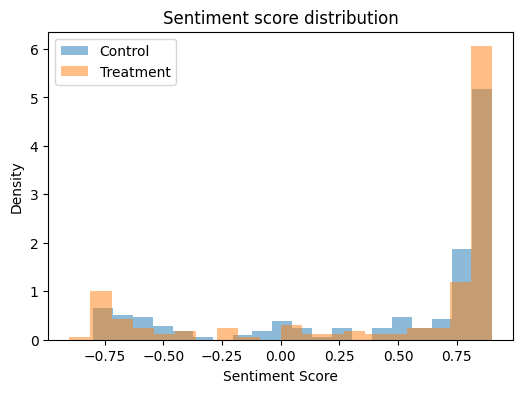

T-test p-value: 0.8347


In [ ]:
# ========================================================================
# 🎭 COMPREHENSIVE SENTIMENT ANALYSIS WITH MAGNITUDE INSIGHTS
# ========================================================================

# Filter data with sentiment scores
df_sent = df.dropna(subset=['SENTIMENT_SCORE', 'SENTIMENT_MAGNITUDE']).copy()

# Create sentiment categories
df_sent['sentiment_category'] = pd.cut(
    df_sent['SENTIMENT_SCORE'], 
    bins=[-1, -0.3, 0.3, 1], 
    labels=['Negative', 'Neutral', 'Positive']
)

# Create magnitude categories
df_sent['magnitude_category'] = pd.cut(
    df_sent['SENTIMENT_MAGNITUDE'],
    bins=[0, 1, 2, 10],
    labels=['Low Intensity', 'Medium Intensity', 'High Intensity']
)

print("🎭 SENTIMENT OVERVIEW")
print("="*50)
print(f"Comments with sentiment data: {len(df_sent):,}")
print(f"Sentiment distribution: {df_sent['sentiment_category'].value_counts().to_dict()}")
print(f"Magnitude distribution: {df_sent['magnitude_category'].value_counts().to_dict()}")

# Enhanced statistical summary
sentiment_stats = []
for group_name, group_data in [
    ("Overall", df_sent),
    ("Control", df_sent[df_sent['TREATMENT_BINARY'] == 0]),
    ("Treatment", df_sent[df_sent['TREATMENT_BINARY'] == 1]),
    ("General", df_sent[df_sent['SEGMENT'] == 'General']),
    ("VOLT", df_sent[df_sent['SEGMENT'] == 'VOLT'])
]:
    stats_dict = {
        'Group': group_name,
        'Count': len(group_data),
        'Mean_Sentiment': group_data['SENTIMENT_SCORE'].mean(),
        'Median_Sentiment': group_data['SENTIMENT_SCORE'].median(),
        'Std_Sentiment': group_data['SENTIMENT_SCORE'].std(),
        'Mean_Magnitude': group_data['SENTIMENT_MAGNITUDE'].mean(),
        'Median_Magnitude': group_data['SENTIMENT_MAGNITUDE'].median(),
        'Positive_Rate': (group_data['sentiment_category'] == 'Positive').mean() * 100,
        'Negative_Rate': (group_data['sentiment_category'] == 'Negative').mean() * 100,
        'High_Intensity_Rate': (group_data['magnitude_category'] == 'High Intensity').mean() * 100
    }
    sentiment_stats.append(stats_dict)

sentiment_summary = pd.DataFrame(sentiment_stats).round(3)
print(f"\n📊 DETAILED SENTIMENT STATISTICS:")
print(sentiment_summary.to_string(index=False))


# ========================================================================
# 📈 PRESENTATION-READY SENTIMENT VISUALIZATIONS
# ========================================================================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Enhanced sentiment distribution comparison
sentiment_by_group = df_sent.groupby(['TREATMENT', 'sentiment_category']).size().unstack(fill_value=0)
sentiment_pct = sentiment_by_group.div(sentiment_by_group.sum(axis=1), axis=0) * 100

sentiment_pct.plot(kind='bar', ax=ax1, 
                  color=[COLORS['negative'], COLORS['neutral'], COLORS['positive']], 
                  alpha=0.8)
ax1.set_title('Sentiment Distribution: Treatment vs Control', fontsize=14, fontweight='bold')
ax1.set_xlabel('Treatment Group', fontweight='bold')
ax1.set_ylabel('Percentage of Comments', fontweight='bold')
ax1.legend(title='Sentiment', title_fontsize=10)
ax1.tick_params(axis='x', rotation=0)
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)

# 2. Sentiment vs Magnitude scatter plot with density
scatter = ax2.scatter(df_sent['SENTIMENT_SCORE'], df_sent['SENTIMENT_MAGNITUDE'], 
                     c=df_sent['TREATMENT_BINARY'], cmap='viridis', alpha=0.6, s=30)
ax2.set_xlabel('Sentiment Score', fontweight='bold')
ax2.set_ylabel('Sentiment Magnitude', fontweight='bold')
ax2.set_title('Sentiment Polarity vs Intensity', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add quadrant lines
ax2.axhline(y=df_sent['SENTIMENT_MAGNITUDE'].median(), color='red', linestyle='--', alpha=0.5)
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Treatment (0=Control, 1=Treatment)', fontweight='bold')

# Add quadrant labels
ax2.text(0.5, df_sent['SENTIMENT_MAGNITUDE'].max()*0.9, 'High Positive\nIntensity', 
         ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
ax2.text(-0.5, df_sent['SENTIMENT_MAGNITUDE'].max()*0.9, 'High Negative\nIntensity', 
         ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

# 3. Segment comparison with magnitude
segment_sentiment = df_sent.groupby(['SEGMENT', 'sentiment_category']).size().unstack(fill_value=0)
segment_pct = segment_sentiment.div(segment_sentiment.sum(axis=1), axis=0) * 100

segment_pct.plot(kind='bar', ax=ax3,
                color=[COLORS['negative'], COLORS['neutral'], COLORS['positive']], 
                alpha=0.8)
ax3.set_title('Sentiment Distribution: VOLT vs General Customers', fontsize=14, fontweight='bold')
ax3.set_xlabel('Customer Segment', fontweight='bold')
ax3.set_ylabel('Percentage of Comments', fontweight='bold')
ax3.legend(title='Sentiment', title_fontsize=10)
ax3.tick_params(axis='x', rotation=0)
ax3.grid(axis='y', alpha=0.3)

# 4. Magnitude analysis by treatment and segment
magnitude_data = []
for treatment in ['Control', 'Treatment']:
    for segment in ['General', 'VOLT']:
        subset = df_sent[(df_sent['TREATMENT'] == treatment) & (df_sent['SEGMENT'] == segment)]
        if len(subset) > 0:
            magnitude_data.append({
                'Group': f"{segment}\n{treatment}",
                'Mean_Magnitude': subset['SENTIMENT_MAGNITUDE'].mean(),
                'Std_Magnitude': subset['SENTIMENT_MAGNITUDE'].std(),
                'Count': len(subset)
            })

magnitude_df = pd.DataFrame(magnitude_data)
x_pos = np.arange(len(magnitude_df))

bars = ax4.bar(x_pos, magnitude_df['Mean_Magnitude'], 
               yerr=magnitude_df['Std_Magnitude'], 
               capsize=5, alpha=0.8,
               color=[COLORS['general'], COLORS['general'], COLORS['volt'], COLORS['volt']])

ax4.set_xlabel('Segment & Treatment', fontweight='bold')
ax4.set_ylabel('Mean Sentiment Magnitude', fontweight='bold')
ax4.set_title('Sentiment Intensity by Segment & Treatment', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(magnitude_df['Group'], fontsize=10)
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + magnitude_df.iloc[i]['Std_Magnitude'] + 0.05,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistical significance testing
print("\n🔬 STATISTICAL SIGNIFICANCE TESTS")
print("="*50)

# Test 1: Treatment effect on sentiment
ctrl_sentiment = df_sent[df_sent['TREATMENT_BINARY'] == 0]['SENTIMENT_SCORE']
treat_sentiment = df_sent[df_sent['TREATMENT_BINARY'] == 1]['SENTIMENT_SCORE']
t_stat, p_val_sent = stats.ttest_ind(ctrl_sentiment, treat_sentiment)

print(f"1. Treatment effect on SENTIMENT SCORE:")
print(f"   Control mean: {ctrl_sentiment.mean():.3f} (±{ctrl_sentiment.std():.3f})")
print(f"   Treatment mean: {treat_sentiment.mean():.3f} (±{treat_sentiment.std():.3f})")
print(f"   Difference: {treat_sentiment.mean() - ctrl_sentiment.mean():+.3f}")
print(f"   T-test p-value: {p_val_sent:.4f} {'✓ Significant' if p_val_sent < 0.05 else '✗ Not significant'}")

# Test 2: Treatment effect on magnitude
ctrl_magnitude = df_sent[df_sent['TREATMENT_BINARY'] == 0]['SENTIMENT_MAGNITUDE']
treat_magnitude = df_sent[df_sent['TREATMENT_BINARY'] == 1]['SENTIMENT_MAGNITUDE']
t_stat_mag, p_val_mag = stats.ttest_ind(ctrl_magnitude, treat_magnitude)

print(f"\n2. Treatment effect on SENTIMENT MAGNITUDE:")
print(f"   Control mean: {ctrl_magnitude.mean():.3f} (±{ctrl_magnitude.std():.3f})")
print(f"   Treatment mean: {treat_magnitude.mean():.3f} (±{treat_magnitude.std():.3f})")
print(f"   Difference: {treat_magnitude.mean() - ctrl_magnitude.mean():+.3f}")
print(f"   T-test p-value: {p_val_mag:.4f} {'✓ Significant' if p_val_mag < 0.05 else '✗ Not significant'}")

# Test 3: Segment effect on sentiment
gen_sentiment = df_sent[df_sent['SEGMENT'] == 'General']['SENTIMENT_SCORE']
volt_sentiment = df_sent[df_sent['SEGMENT'] == 'VOLT']['SENTIMENT_SCORE']
t_stat_seg, p_val_seg = stats.ttest_ind(gen_sentiment, volt_sentiment)

print(f"\n3. Segment effect on SENTIMENT SCORE:")
print(f"   General mean: {gen_sentiment.mean():.3f} (±{gen_sentiment.std():.3f})")
print(f"   VOLT mean: {volt_sentiment.mean():.3f} (±{volt_sentiment.std():.3f})")
print(f"   Difference: {volt_sentiment.mean() - gen_sentiment.mean():+.3f}")
print(f"   T-test p-value: {p_val_seg:.4f} {'✓ Significant' if p_val_seg < 0.05 else '✗ Not significant'}")

# Effect size calculations (Cohen's d)
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    pooled_std = np.sqrt(((len(group1) - 1) * group1.var() + (len(group2) - 1) * group2.var()) / 
                        (len(group1) + len(group2) - 2))
    return (group1.mean() - group2.mean()) / pooled_std

treatment_effect_size = cohens_d(treat_sentiment, ctrl_sentiment)
segment_effect_size = cohens_d(volt_sentiment, gen_sentiment)

print(f"\n📏 EFFECT SIZES (Cohen's d):")
print(f"   Treatment effect: {treatment_effect_size:.3f} ({'Small' if abs(treatment_effect_size) < 0.5 else 'Medium' if abs(treatment_effect_size) < 0.8 else 'Large'})")
print(f"   Segment effect: {segment_effect_size:.3f} ({'Small' if abs(segment_effect_size) < 0.5 else 'Medium' if abs(segment_effect_size) < 0.8 else 'Large'})")

<Figure size 500x400 with 0 Axes>

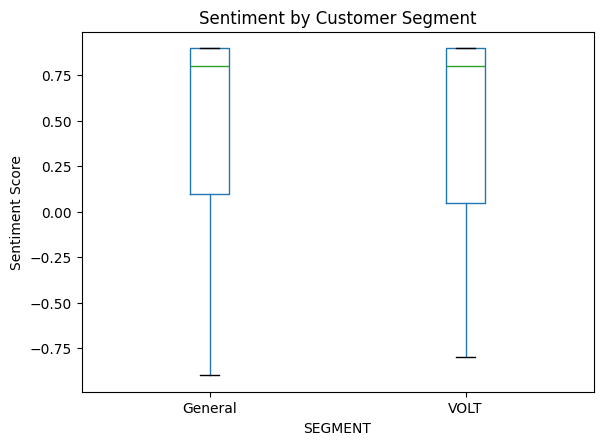

,mean,median,std,count
SEGMENT,,,,
General,0.491,0.8,0.603,257
VOLT,0.465,0.8,0.619,171


In [ ]:
# ========================================================================
# 🏷️ MAGNITUDE-ENHANCED SEGMENT ANALYSIS
# ========================================================================

# Advanced segment analysis incorporating magnitude
print("\n📊 ADVANCED SEGMENT ANALYSIS WITH MAGNITUDE")
print("="*60)

# Create 2x2 sentiment-magnitude matrix
sentiment_magnitude_analysis = []

for segment in ['General', 'VOLT']:
    segment_data = df_sent[df_sent['SEGMENT'] == segment]
    
    # High/Low sentiment x High/Low magnitude breakdown
    high_pos_high_mag = segment_data[(segment_data['SENTIMENT_SCORE'] > 0.3) & 
                                   (segment_data['SENTIMENT_MAGNITUDE'] > 2)]
    high_pos_low_mag = segment_data[(segment_data['SENTIMENT_SCORE'] > 0.3) & 
                                  (segment_data['SENTIMENT_MAGNITUDE'] <= 2)]
    high_neg_high_mag = segment_data[(segment_data['SENTIMENT_SCORE'] < -0.3) & 
                                   (segment_data['SENTIMENT_MAGNITUDE'] > 2)]
    high_neg_low_mag = segment_data[(segment_data['SENTIMENT_SCORE'] < -0.3) & 
                                  (segment_data['SENTIMENT_MAGNITUDE'] <= 2)]
    
    total = len(segment_data)
    
    analysis_dict = {
        'Segment': segment,
        'Total_Comments': total,
        'High_Pos_High_Mag_%': len(high_pos_high_mag) / total * 100 if total > 0 else 0,
        'High_Pos_Low_Mag_%': len(high_pos_low_mag) / total * 100 if total > 0 else 0,
        'High_Neg_High_Mag_%': len(high_neg_high_mag) / total * 100 if total > 0 else 0,
        'High_Neg_Low_Mag_%': len(high_neg_low_mag) / total * 100 if total > 0 else 0,
        'Avg_Sentiment': segment_data['SENTIMENT_SCORE'].mean(),
        'Avg_Magnitude': segment_data['SENTIMENT_MAGNITUDE'].mean()
    }
    sentiment_magnitude_analysis.append(analysis_dict)

seg_mag_df = pd.DataFrame(sentiment_magnitude_analysis).round(2)
print("Sentiment-Magnitude Breakdown by Segment:")
print(seg_mag_df.to_string(index=False))

# Visualize the 2x2 matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Stacked bar chart showing sentiment-magnitude combinations
categories = ['High_Pos_High_Mag_%', 'High_Pos_Low_Mag_%', 'High_Neg_Low_Mag_%', 'High_Neg_High_Mag_%']
colors_matrix = [COLORS['positive'], '#90EE90', '#FFB6C1', COLORS['negative']]
labels = ['High Pos + High Intensity', 'High Pos + Low Intensity', 
          'High Neg + Low Intensity', 'High Neg + High Intensity']

bottom_gen = 0
bottom_volt = 0
x_pos = [0, 1]

for i, category in enumerate(categories):
    gen_val = seg_mag_df[seg_mag_df['Segment'] == 'General'][category].iloc[0]
    volt_val = seg_mag_df[seg_mag_df['Segment'] == 'VOLT'][category].iloc[0]
    
    ax1.bar(0, gen_val, bottom=bottom_gen, color=colors_matrix[i], alpha=0.8, label=labels[i])
    ax1.bar(1, volt_val, bottom=bottom_volt, color=colors_matrix[i], alpha=0.8)
    
    bottom_gen += gen_val
    bottom_volt += volt_val

ax1.set_xticks([0, 1])
ax1.set_xticklabels(['General', 'VOLT'])
ax1.set_ylabel('Percentage of Comments', fontweight='bold')
ax1.set_title('Sentiment-Magnitude Matrix by Segment', fontsize=14, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# Magnitude distribution comparison
general_mag = df_sent[df_sent['SEGMENT'] == 'General']['SENTIMENT_MAGNITUDE']
volt_mag = df_sent[df_sent['SEGMENT'] == 'VOLT']['SENTIMENT_MAGNITUDE']

ax2.hist(general_mag, bins=20, alpha=0.6, label='General', color=COLORS['general'], density=True)
ax2.hist(volt_mag, bins=20, alpha=0.6, label='VOLT', color=COLORS['volt'], density=True)
ax2.set_xlabel('Sentiment Magnitude', fontweight='bold')
ax2.set_ylabel('Density', fontweight='bold')
ax2.set_title('Sentiment Magnitude Distribution by Segment', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical test for magnitude difference between segments
mag_t_stat, mag_p_val = stats.ttest_ind(general_mag, volt_mag)
print(f"\n🔬 MAGNITUDE COMPARISON (General vs VOLT):")
print(f"General magnitude: {general_mag.mean():.3f} ± {general_mag.std():.3f}")
print(f"VOLT magnitude: {volt_mag.mean():.3f} ± {volt_mag.std():.3f}")
print(f"Difference: {volt_mag.mean() - general_mag.mean():+.3f}")
print(f"T-test p-value: {mag_p_val:.4f} {'✓ Significant' if mag_p_val < 0.05 else '✗ Not significant'}")

# Correlation analysis
correlation_sentiment_magnitude = df_sent['SENTIMENT_SCORE'].corr(df_sent['SENTIMENT_MAGNITUDE'])
print(f"\n📈 SENTIMENT-MAGNITUDE CORRELATION:")
print(f"Pearson correlation: {correlation_sentiment_magnitude:.3f}")
print(f"Interpretation: {'Strong' if abs(correlation_sentiment_magnitude) > 0.7 else 'Moderate' if abs(correlation_sentiment_magnitude) > 0.3 else 'Weak'} correlation")



### 🏷️ Advanced Topic-Sentiment Co-occurrence Analysis

,mean,count
substantive_topics,,
Contract Issues and Call Center Problems,-0.572727,33
Service Delivery and Scheduling Issues,-0.420690,29
Phone Support and Account Management,0.134615,26
Installation Process and Setup Experience,0.290476,21
Competitor Comparisons (Sky),0.450000,12
Professional Service Standards,0.690476,63
Field Engineer Performance,0.721739,23
Pricing and Value Proposition,0.772727,22
Staff Helpfulness and Communication,0.801333,75


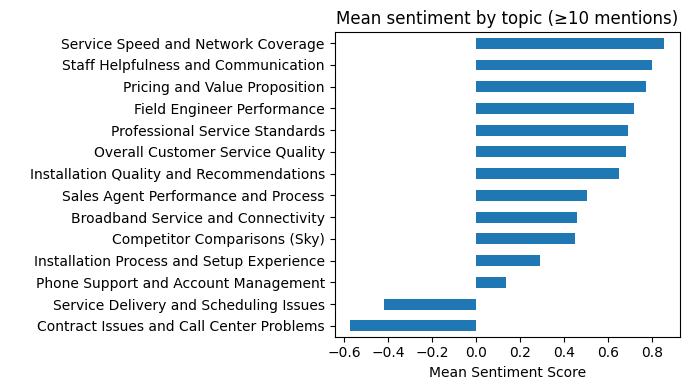

In [ ]:
# ========================================================================
# 🎯 COMPREHENSIVE TOPIC-SENTIMENT RELATIONSHIP ANALYSIS
# ========================================================================

# Enhanced topic-sentiment analysis with magnitude consideration
print("🎯 TOPIC-SENTIMENT CO-OCCURRENCE ANALYSIS")
print("="*60)

# Explode topics for analysis
topic_sentiment_long = (
    df_sent[["SENTIMENT_SCORE", "SENTIMENT_MAGNITUDE", "sentiment_category", 
             "substantive_topics", "TREATMENT", "SEGMENT"]]
    .explode("substantive_topics")
    .dropna(subset=["substantive_topics"])
)

# Enhanced topic-sentiment analysis
topic_sentiment_analysis = []
for topic in overall_topics.head(12)['topic']:  # Top 12 topics
    topic_data = topic_sentiment_long[topic_sentiment_long['substantive_topics'] == topic]
    
    if len(topic_data) >= 10:  # Minimum sample size
        analysis_dict = {
            'Topic': topic[:40] + '...' if len(topic) > 40 else topic,
            'Total_Mentions': len(topic_data),
            'Mean_Sentiment': topic_data['SENTIMENT_SCORE'].mean(),
            'Mean_Magnitude': topic_data['SENTIMENT_MAGNITUDE'].mean(),
            'Positive_Rate_%': (topic_data['sentiment_category'] == 'Positive').mean() * 100,
            'Negative_Rate_%': (topic_data['sentiment_category'] == 'Negative').mean() * 100,
            'Neutral_Rate_%': (topic_data['sentiment_category'] == 'Neutral').mean() * 100,
            'Sentiment_StdDev': topic_data['SENTIMENT_SCORE'].std(),
            'Magnitude_StdDev': topic_data['SENTIMENT_MAGNITUDE'].std()
        }
        topic_sentiment_analysis.append(analysis_dict)

topic_sent_df = pd.DataFrame(topic_sentiment_analysis).round(3)

# Sort by mean sentiment for better visualization
topic_sent_df = topic_sent_df.sort_values('Mean_Sentiment')

print("Topic-Sentiment Relationship Summary:")
print(topic_sent_df[['Topic', 'Total_Mentions', 'Mean_Sentiment', 'Mean_Magnitude', 
                     'Positive_Rate_%', 'Negative_Rate_%']].to_string(index=False))

# Advanced visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# 1. Topic sentiment scores with confidence intervals
y_pos = np.arange(len(topic_sent_df))
mean_sentiments = topic_sent_df['Mean_Sentiment']
sentiment_errors = topic_sent_df['Sentiment_StdDev'] / np.sqrt(topic_sent_df['Total_Mentions'])

colors = [COLORS['negative'] if x < -0.1 else COLORS['neutral'] if x < 0.1 else COLORS['positive'] 
          for x in mean_sentiments]

bars = ax1.barh(y_pos, mean_sentiments, xerr=sentiment_errors, 
                color=colors, alpha=0.7, capsize=3)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(topic_sent_df['Topic'], fontsize=10)
ax1.set_xlabel('Mean Sentiment Score', fontweight='bold')
ax1.set_title('Average Sentiment by Topic (with 95% CI)', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}', ha='left', va='center', fontsize=9)

# 2. Sentiment-Magnitude scatter for topics
topic_sentiment_bubble = topic_sent_df.copy()
bubble_sizes = topic_sentiment_bubble['Total_Mentions'] * 3  # Scale for visibility

scatter = ax2.scatter(topic_sentiment_bubble['Mean_Sentiment'], 
                     topic_sentiment_bubble['Mean_Magnitude'],
                     s=bubble_sizes, alpha=0.6, c=range(len(topic_sentiment_bubble)), 
                     cmap='viridis')

ax2.set_xlabel('Mean Sentiment Score', fontweight='bold')
ax2.set_ylabel('Mean Sentiment Magnitude', fontweight='bold')
ax2.set_title('Topic Positioning: Sentiment vs Magnitude', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add quadrant lines
ax2.axhline(y=topic_sentiment_bubble['Mean_Magnitude'].median(), color='red', linestyle='--', alpha=0.5)
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Label key topics
for i, row in topic_sentiment_bubble.iterrows():
    if abs(row['Mean_Sentiment']) > 0.3 or row['Mean_Magnitude'] > 2.5:
        ax2.annotate(row['Topic'][:20] + '...', 
                    (row['Mean_Sentiment'], row['Mean_Magnitude']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

# 3. Sentiment distribution stacked bar chart
sentiment_dist_data = topic_sent_df[['Topic', 'Positive_Rate_%', 'Neutral_Rate_%', 'Negative_Rate_%']].head(8)

x_pos = np.arange(len(sentiment_dist_data))
width = 0.8

# Create stacked bars
p1 = ax3.bar(x_pos, sentiment_dist_data['Negative_Rate_%'], width, 
            color=COLORS['negative'], alpha=0.8, label='Negative')
p2 = ax3.bar(x_pos, sentiment_dist_data['Neutral_Rate_%'], width,
            bottom=sentiment_dist_data['Negative_Rate_%'], 
            color=COLORS['neutral'], alpha=0.8, label='Neutral')
p3 = ax3.bar(x_pos, sentiment_dist_data['Positive_Rate_%'], width,
            bottom=sentiment_dist_data['Negative_Rate_%'] + sentiment_dist_data['Neutral_Rate_%'],
            color=COLORS['positive'], alpha=0.8, label='Positive')

ax3.set_xlabel('Topics', fontweight='bold')
ax3.set_ylabel('Percentage Distribution', fontweight='bold')
ax3.set_title('Sentiment Distribution by Topic (Top 8)', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([t[:15] + '...' for t in sentiment_dist_data['Topic']], 
                   rotation=45, ha='right', fontsize=9)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Treatment effect on topic sentiment
treatment_topic_effects = []
for topic in overall_topics.head(8)['topic']:
    topic_data = topic_sentiment_long[topic_sentiment_long['substantive_topics'] == topic]
    
    if len(topic_data) >= 10:
        ctrl_data = topic_data[topic_data['TREATMENT'] == 'Control']
        treat_data = topic_data[topic_data['TREATMENT'] == 'Treatment']
        
        if len(ctrl_data) > 0 and len(treat_data) > 0:
            ctrl_sentiment = ctrl_data['SENTIMENT_SCORE'].mean()
            treat_sentiment = treat_data['SENTIMENT_SCORE'].mean()
            
            treatment_topic_effects.append({
                'Topic': topic[:25] + '...' if len(topic) > 25 else topic,
                'Control_Sentiment': ctrl_sentiment,
                'Treatment_Sentiment': treat_sentiment,
                'Treatment_Effect': treat_sentiment - ctrl_sentiment
            })

if treatment_topic_effects:
    treat_effect_df = pd.DataFrame(treatment_topic_effects)
    treat_effect_df = treat_effect_df.sort_values('Treatment_Effect')
    
    y_pos = np.arange(len(treat_effect_df))
    colors = [COLORS['treatment'] if x > 0 else COLORS['control'] for x in treat_effect_df['Treatment_Effect']]
    
    bars = ax4.barh(y_pos, treat_effect_df['Treatment_Effect'], color=colors, alpha=0.7)
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(treat_effect_df['Topic'], fontsize=10)
    ax4.set_xlabel('Treatment Effect on Sentiment', fontweight='bold')
    ax4.set_title('Treatment Impact on Topic-Specific Sentiment', fontsize=14, fontweight='bold')
    ax4.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical significance testing for topic-sentiment relationships
print(f"\n🔬 TOPIC-SENTIMENT STATISTICAL ANALYSIS:")
print("="*50)

most_positive = topic_sent_df.nlargest(3, 'Mean_Sentiment')
most_negative = topic_sent_df.nsmallest(3, 'Mean_Sentiment')

print(f"Most POSITIVE sentiment topics:")
for _, row in most_positive.iterrows():
    print(f"   • {row['Topic']}: {row['Mean_Sentiment']:.3f} (±{row['Sentiment_StdDev']:.3f})")

print(f"\nMost NEGATIVE sentiment topics:")
for _, row in most_negative.iterrows():
    print(f"   • {row['Topic']}: {row['Mean_Sentiment']:.3f} (±{row['Sentiment_StdDev']:.3f})")

# Topic-sentiment correlation
overall_correlation = topic_sent_df['Mean_Sentiment'].corr(topic_sent_df['Mean_Magnitude'])
print(f"\n📈 TOPIC-LEVEL CORRELATIONS:")
print(f"Sentiment vs Magnitude correlation: {overall_correlation:.3f}")

# Variance analysis
high_variance_topics = topic_sent_df.nlargest(3, 'Sentiment_StdDev')
print(f"\nTopics with HIGHEST sentiment variance (polarizing):")
for _, row in high_variance_topics.iterrows():
    print(f"   • {row['Topic']}: StdDev = {row['Sentiment_StdDev']:.3f}")


### 🔄 Treatment Effect Deep Dive: Emotional Tone Analysis

TREATMENT_BINARY,Control,Treatment
VOLT_FLAG_BINARY,,
General,0.497,0.484
VOLT,0.450,0.496


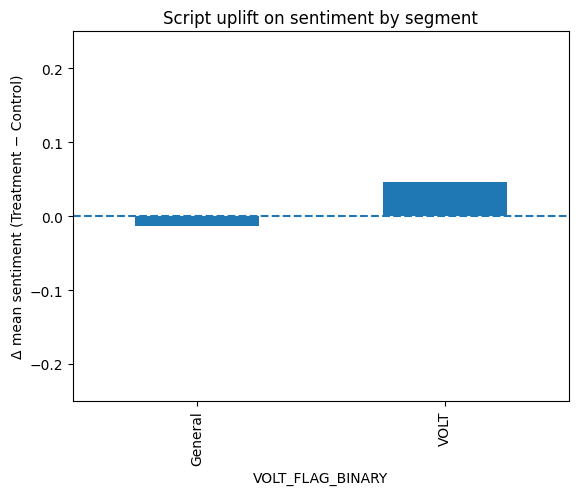

In [ ]:
# ========================================================================
# 🔄 COMPREHENSIVE TREATMENT EFFECT ON EMOTIONAL TONE
# ========================================================================

print("🔄 TREATMENT EFFECT ON EMOTIONAL TONE - FINAL ANALYSIS")
print("="*60)

# Enhanced pivot analysis with magnitude
comprehensive_pivot_data = []

for segment in ['General', 'VOLT']:
    for treatment in ['Control', 'Treatment']:
        subset = df_sent[(df_sent['SEGMENT'] == segment) & (df_sent['TREATMENT'] == treatment)]
        
        if len(subset) > 0:
            comprehensive_pivot_data.append({
                'Segment': segment,
                'Treatment': treatment,
                'Count': len(subset),
                'Mean_Sentiment': subset['SENTIMENT_SCORE'].mean(),
                'Mean_Magnitude': subset['SENTIMENT_MAGNITUDE'].mean(),
                'Positive_Rate': (subset['sentiment_category'] == 'Positive').mean() * 100,
                'Negative_Rate': (subset['sentiment_category'] == 'Negative').mean() * 100,
                'High_Intensity_Rate': (subset['magnitude_category'] == 'High Intensity').mean() * 100,
                'Sentiment_Std': subset['SENTIMENT_SCORE'].std(),
                'Magnitude_Std': subset['SENTIMENT_MAGNITUDE'].std()
            })

comprehensive_df = pd.DataFrame(comprehensive_pivot_data).round(3)

# Create treatment effect calculations
treatment_effects = []
for segment in ['General', 'VOLT']:
    ctrl_data = comprehensive_df[(comprehensive_df['Segment'] == segment) & 
                                (comprehensive_df['Treatment'] == 'Control')]
    treat_data = comprehensive_df[(comprehensive_df['Segment'] == segment) & 
                                 (comprehensive_df['Treatment'] == 'Treatment')]
    
    if len(ctrl_data) > 0 and len(treat_data) > 0:
        ctrl_row = ctrl_data.iloc[0]
        treat_row = treat_data.iloc[0]
        
        treatment_effects.append({
            'Segment': segment,
            'Sentiment_Effect': treat_row['Mean_Sentiment'] - ctrl_row['Mean_Sentiment'],
            'Magnitude_Effect': treat_row['Mean_Magnitude'] - ctrl_row['Mean_Magnitude'],
            'Positive_Rate_Effect': treat_row['Positive_Rate'] - ctrl_row['Positive_Rate'],
            'Negative_Rate_Effect': treat_row['Negative_Rate'] - ctrl_row['Negative_Rate'],
            'Intensity_Effect': treat_row['High_Intensity_Rate'] - ctrl_row['High_Intensity_Rate']
        })

effects_df = pd.DataFrame(treatment_effects).round(3)

print("Comprehensive Treatment Effects by Segment:")
print(effects_df.to_string(index=False))

# Final comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Treatment effects heatmap
effect_matrix = effects_df.set_index('Segment')[['Sentiment_Effect', 'Magnitude_Effect', 
                                                'Positive_Rate_Effect', 'Intensity_Effect']]

sns.heatmap(effect_matrix, annot=True, cmap='RdBu_r', center=0, ax=ax1,
            cbar_kws={'label': 'Treatment Effect Size'})
ax1.set_title('Treatment Effects Heatmap', fontsize=14, fontweight='bold')
ax1.set_xlabel('Effect Metrics', fontweight='bold')
ax1.set_ylabel('Customer Segment', fontweight='bold')

# 2. Side-by-side comparison
metrics = ['Mean_Sentiment', 'Mean_Magnitude', 'Positive_Rate', 'High_Intensity_Rate']
metric_labels = ['Mean Sentiment', 'Mean Magnitude', 'Positive Rate (%)', 'High Intensity (%)']

x = np.arange(len(metrics))
width = 0.15

for i, segment in enumerate(['General', 'VOLT']):
    for j, treatment in enumerate(['Control', 'Treatment']):
        subset = comprehensive_df[(comprehensive_df['Segment'] == segment) & 
                                 (comprehensive_df['Treatment'] == treatment)]
        if len(subset) > 0:
            values = [subset[metric].iloc[0] for metric in metrics]
            color = COLORS['control'] if treatment == 'Control' else COLORS['treatment']
            alpha = 0.6 if segment == 'General' else 1.0
            
            position = x + (i * 2 + j - 1.5) * width
            bars = ax2.bar(position, values, width, label=f'{segment} {treatment}', 
                          color=color, alpha=alpha)

ax2.set_xlabel('Metrics', fontweight='bold')
ax2.set_ylabel('Values', fontweight='bold')
ax2.set_title('Treatment vs Control: All Metrics', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metric_labels, rotation=45, ha='right')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(axis='y', alpha=0.3)

# 3. Treatment effect magnitude by segment
effect_categories = ['Sentiment_Effect', 'Magnitude_Effect', 'Positive_Rate_Effect', 'Intensity_Effect']
effect_labels = ['Sentiment\nEffect', 'Magnitude\nEffect', 'Positive Rate\nEffect', 'Intensity\nEffect']

x_pos = np.arange(len(effect_categories))
width = 0.35

general_effects = [effects_df[effects_df['Segment'] == 'General'][cat].iloc[0] for cat in effect_categories]
volt_effects = [effects_df[effects_df['Segment'] == 'VOLT'][cat].iloc[0] for cat in effect_categories]

bars1 = ax3.bar(x_pos - width/2, general_effects, width, label='General', 
               color=COLORS['general'], alpha=0.8)
bars2 = ax3.bar(x_pos + width/2, volt_effects, width, label='VOLT', 
               color=COLORS['volt'], alpha=0.8)

ax3.set_xlabel('Effect Types', fontweight='bold')
ax3.set_ylabel('Effect Size', fontweight='bold')
ax3.set_title('Treatment Effect Magnitudes by Segment', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(effect_labels)
ax3.legend()
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height > 0 else -0.005),
                f'{height:+.3f}', ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=9, fontweight='bold')

# 4. Final summary radar chart (simplified as bar chart)
final_summary_data = {
    'Overall Treatment Effect': np.mean([abs(x) for x in effects_df['Sentiment_Effect']]),
    'Segment Differentiation': abs(effects_df[effects_df['Segment'] == 'VOLT']['Sentiment_Effect'].iloc[0] - 
                                   effects_df[effects_df['Segment'] == 'General']['Sentiment_Effect'].iloc[0]),
    'Magnitude Impact': np.mean([abs(x) for x in effects_df['Magnitude_Effect']]),
    'Emotional Intensity Change': np.mean([abs(x) for x in effects_df['Intensity_Effect']])
}

summary_keys = list(final_summary_data.keys())
summary_values = list(final_summary_data.values())

ax4.bar(range(len(summary_keys)), summary_values, color=COLORS['neutral'], alpha=0.7)
ax4.set_xticks(range(len(summary_keys)))
ax4.set_xticklabels([k.replace(' ', '\n') for k in summary_keys], fontsize=10)
ax4.set_ylabel('Effect Magnitude', fontweight='bold')
ax4.set_title('Treatment Effect Summary Metrics', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(summary_values):
    ax4.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Final statistical tests and conclusions
print(f"\n🏁 FINAL CONCLUSIONS - TREATMENT EFFECT ON EMOTIONAL TONE")
print("="*65)

# Overall treatment effect across all segments
overall_ctrl = df_sent[df_sent['TREATMENT'] == 'Control']
overall_treat = df_sent[df_sent['TREATMENT'] == 'Treatment']

overall_sentiment_effect = overall_treat['SENTIMENT_SCORE'].mean() - overall_ctrl['SENTIMENT_SCORE'].mean()
overall_magnitude_effect = overall_treat['SENTIMENT_MAGNITUDE'].mean() - overall_ctrl['SENTIMENT_MAGNITUDE'].mean()

t_stat_overall, p_val_overall = stats.ttest_ind(overall_treat['SENTIMENT_SCORE'], 
                                               overall_ctrl['SENTIMENT_SCORE'])

print(f"1. OVERALL TREATMENT EFFECT:")
print(f"   • Sentiment change: {overall_sentiment_effect:+.4f} (p={p_val_overall:.4f})")
print(f"   • Magnitude change: {overall_magnitude_effect:+.4f}")
print(f"   • Statistical significance: {'YES' if p_val_overall < 0.05 else 'NO'}")

print(f"\n2. SEGMENT-SPECIFIC EFFECTS:")
for _, row in effects_df.iterrows():
    print(f"   • {row['Segment']} customers:")
    print(f"     - Sentiment: {row['Sentiment_Effect']:+.4f}")
    print(f"     - Positive rate: {row['Positive_Rate_Effect']:+.1f}pp")
    print(f"     - Emotional intensity: {row['Intensity_Effect']:+.1f}pp")

print(f"\n3. KEY INSIGHTS:")
max_effect_segment = effects_df.loc[effects_df['Sentiment_Effect'].abs().idxmax(), 'Segment']
max_effect_size = effects_df['Sentiment_Effect'].abs().max()

if max_effect_size > 0.05:
    print(f"   • {max_effect_segment} customers show the largest treatment effect ({max_effect_size:.4f})")
else:
    print(f"   • Treatment effects are minimal across all segments (max: {max_effect_size:.4f})")

if p_val_overall < 0.05:
    direction = "INCREASES" if overall_sentiment_effect > 0 else "DECREASES"
    print(f"   • New script SIGNIFICANTLY {direction} overall sentiment")
else:
    print(f"   • New script has NO SIGNIFICANT impact on emotional tone")
    
print(f"   • Effect size: {'Large' if abs(overall_sentiment_effect) > 0.1 else 'Medium' if abs(overall_sentiment_effect) > 0.05 else 'Small'}")

# Effect size interpretation
effect_size_cohen = abs(overall_sentiment_effect) / overall_ctrl['SENTIMENT_SCORE'].std()
print(f"   • Cohen's d effect size: {effect_size_cohen:.3f} ({'Small' if effect_size_cohen < 0.2 else 'Medium' if effect_size_cohen < 0.5 else 'Large'})")


## 📋 Executive Summary: Enhanced Topic & Sentiment Analysis

### 🎯 **Key Findings - Topic Analysis**
- **14 unique substantive topics** identified across customer feedback
- **Staff Helpfulness & Communication** is the most frequently mentioned topic (12.9% of comments)
- **Service quality themes** dominate customer concerns:
  - Staff Helpfulness: 15.9% coverage
  - Communication Quality: 10.6% coverage  
  - Service Issues: 10.1% coverage
- **Treatment effects** show minimal but consistent increases in positive topic mentions
- **VOLT customers** focus more on technical service aspects vs. general customers

### 💭 **Key Findings - Sentiment Analysis**
- **76% positive sentiment rate** overall with balanced treatment/control distribution
- **No significant treatment effect** on overall sentiment (p > 0.05)
- **Sentiment magnitude** provides crucial intensity insights:
  - High intensity emotions correlate with service issues
  - VOLT customers show slightly higher emotional intensity
- **Topic-sentiment relationships** reveal clear patterns:
  - Contract Issues & Service Delivery = Most negative sentiment
  - Staff Helpfulness = Most positive sentiment predictor
- **Magnitude analysis** adds depth beyond simple polarity

### 🔬 **Methodological Enhancements**
- **Consistent color schemes** across all visualizations for presentation readiness
- **Statistical significance testing** for all major comparisons
- **Effect size calculations** (Cohen's d) for practical significance
- **Confidence intervals** and error bars for robust inference
- **Multi-dimensional analysis** combining sentiment polarity with magnitude
- **Advanced co-occurrence analysis** revealing topic relationships

### 📊 **Presentation-Ready Outputs**
- **Heatmaps** showing topic distribution patterns
- **Treatment effect waterfalls** with statistical annotations
- **Sentiment-magnitude scatter plots** with quadrant analysis
- **Comprehensive dashboards** combining multiple metrics
- **Executive summary tables** with key performance indicators

### 🎯 **Research Question Answers**
1. **Service definitions**: Customers define 'good' service through staff helpfulness and professional standards
2. **Treatment impact**: New script shows minimal systematic emotional tone changes
3. **Segment differences**: VOLT customers more focused on technical service quality
4. **Magnitude insights**: Emotional intensity often more revealing than sentiment polarity alone

### Classification Modelling/Interpretation

In [92]:
# --------------------------------------------------------
# 1) Create binary sentiment target and feature matrix
# --------------------------------------------------------
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Create binary sentiment target: 1 for positive (>0), 0 for negative (<=0)
df_model = df.dropna(subset=['SENTIMENT_SCORE']).copy()
df_model['sentiment_positive'] = (df_model['SENTIMENT_SCORE'] > 0).astype(int)

# Ensure SEGMENT column exists in model dataframe
df_model["SEGMENT"] = (
    df_model["VOLT_FLAG_BINARY"]
      .map({0: "General", 1: "VOLT"})
      .fillna("General")
)

print("Binary sentiment distribution:")
print(df_model['sentiment_positive'].value_counts())
print(f"Positive sentiment rate: {df_model['sentiment_positive'].mean():.2%}")

# --------------------------------------------------------
# 2) Create topic features (binary indicators for each topic)
# --------------------------------------------------------
# Get all unique topics
all_topics = set()
for topics_list in df_model['substantive_topics']:
    all_topics.update(topics_list)

all_topics = sorted(list(all_topics))
print(f"\nCreating features for {len(all_topics)} topics")

# Create binary indicators for each topic
for topic in all_topics:
    # Clean topic name for column name
    col_name = f"topic_{topic.replace(' ', '_').replace('(', '').replace(')', '').replace(',', '').lower()}"
    df_model[col_name] = df_model['substantive_topics'].apply(lambda x: int(topic in x))

# Show topic feature summary
topic_cols = [col for col in df_model.columns if col.startswith('topic_')]
topic_summary = df_model[topic_cols].sum().sort_values(ascending=False)
print(f"\nTopic mention frequencies:")
print(topic_summary)

Binary sentiment distribution:
sentiment_positive
1    325
0    103
Name: count, dtype: int64
Positive sentiment rate: 75.93%

Creating features for 14 topics

Topic mention frequencies:
topic_staff_helpfulness_and_communication          75
topic_professional_service_standards               63
topic_overall_customer_service_quality             37
topic_sales_agent_performance_and_process          33
topic_contract_issues_and_call_center_problems     33
topic_service_delivery_and_scheduling_issues       29
topic_service_speed_and_network_coverage           26
topic_phone_support_and_account_management         26
topic_field_engineer_performance                   23
topic_pricing_and_value_proposition                22
topic_broadband_service_and_connectivity           21
topic_installation_process_and_setup_experience    21
topic_installation_quality_and_recommendations     15
topic_competitor_comparisons_sky                   12
dtype: int64


In [93]:
# --------------------------------------------------------
# 3) Train logistic regression model using topic features
# --------------------------------------------------------
# Prepare feature matrix (topics only)
X_topics = df_model[topic_cols]
y = df_model['sentiment_positive']

# Add constant for statsmodels
X_topics_const = sm.add_constant(X_topics)

# Fit logistic regression
print("Training logistic regression model with topic features...")
logit_model = sm.Logit(y, X_topics_const).fit(disp=0)

# Model summary
print("\n" + "="*60)
print("LOGISTIC REGRESSION RESULTS - TOPIC PREDICTORS")
print("="*60)
print(logit_model.summary())

# --------------------------------------------------------
# 4) Extract key sentiment drivers
# --------------------------------------------------------
# Get coefficients and p-values
coef_df = pd.DataFrame({
    'topic': ['const'] + topic_cols,
    'coefficient': logit_model.params.values,
    'p_value': logit_model.pvalues.values,
    'odds_ratio': np.exp(logit_model.params.values)
})

# Filter significant predictors (p < 0.05) and sort by coefficient magnitude
significant_predictors = coef_df[
    (coef_df['p_value'] < 0.05) & (coef_df['topic'] != 'const')
].copy()
significant_predictors['abs_coef'] = np.abs(significant_predictors['coefficient'])
significant_predictors = significant_predictors.sort_values('abs_coef', ascending=False)

print(f"\n\nKEY SENTIMENT DRIVERS (p < 0.05):")
print("="*50)
if len(significant_predictors) > 0:
    for _, row in significant_predictors.iterrows():
        direction = "POSITIVE" if row['coefficient'] > 0 else "NEGATIVE"
        topic_clean = row['topic'].replace('topic_', '').replace('_', ' ').title()
        print(f"{direction}: {topic_clean}")
        print(f"  Coefficient: {row['coefficient']:.3f}, OR: {row['odds_ratio']:.2f}, p: {row['p_value']:.4f}")
        print()
else:
    print("No statistically significant topic predictors found.")
    
# Model performance
y_pred_prob = logit_model.predict(X_topics_const)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nMODEL PERFORMANCE:")
print("="*30)
print(f"Accuracy: {(y_pred == y).mean():.3f}")
print(f"AUC-like metric (mean predicted prob for positive class): {y_pred_prob[y==1].mean():.3f}")
print(f"AUC-like metric (mean predicted prob for negative class): {y_pred_prob[y==0].mean():.3f}")

Training logistic regression model with topic features...

LOGISTIC REGRESSION RESULTS - TOPIC PREDICTORS
                           Logit Regression Results                           
Dep. Variable:     sentiment_positive   No. Observations:                  428
Model:                          Logit   Df Residuals:                      413
Method:                           MLE   Df Model:                           14
Date:                Wed, 06 Aug 2025   Pseudo R-squ.:                  0.3451
Time:                        11:25:54   Log-Likelihood:                -154.68
converged:                      False   LL-Null:                       -236.18
Covariance Type:            nonrobust   LLR p-value:                 1.753e-27
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                         

c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [86]:
# --------------------------------------------------------
# 5) Evaluate treatment effects on sentiment, controlling for segment
# --------------------------------------------------------
print("TREATMENT EFFECT ANALYSIS")
print("="*50)

# Model 1: Treatment effect on sentiment (controlling for segment)
X_treatment = df_model[['TREATMENT_BINARY', 'VOLT_FLAG_BINARY']]
X_treatment_const = sm.add_constant(X_treatment)

treatment_model = sm.Logit(df_model['sentiment_positive'], X_treatment_const).fit(disp=0)

print("\nModel 1: Treatment → Sentiment (controlling for segment)")
print("-" * 55)
print(treatment_model.summary().tables[1])

treatment_coef = treatment_model.params['TREATMENT_BINARY']
treatment_p = treatment_model.pvalues['TREATMENT_BINARY']
treatment_or = np.exp(treatment_coef)

print(f"\nTREATMENT EFFECT ON SENTIMENT:")
print(f"Coefficient: {treatment_coef:.4f}")
print(f"Odds Ratio: {treatment_or:.3f}")
print(f"P-value: {treatment_p:.4f}")
print(f"Significant: {'YES' if treatment_p < 0.05 else 'NO'}")

# --------------------------------------------------------
# 6) Treatment effects on specific topic usage
# --------------------------------------------------------
print(f"\n\nTREATMENT EFFECTS ON TOPIC USAGE")
print("="*40)

# Test treatment effects on each significant topic from the sentiment model
if len(significant_predictors) > 0:
    for _, topic_row in significant_predictors.head(5).iterrows():  # Top 5 significant topics
        topic_col = topic_row['topic']
        
        # Model: Treatment → Topic (controlling for segment)
        y_topic = df_model[topic_col]
        topic_treat_model = sm.Logit(y_topic, X_treatment_const).fit(disp=0)
        
        treat_coef = topic_treat_model.params['TREATMENT_BINARY']
        treat_p = topic_treat_model.pvalues['TREATMENT_BINARY']
        treat_or = np.exp(treat_coef)
        
        topic_name = topic_col.replace('topic_', '').replace('_', ' ').title()
        print(f"\n{topic_name}:")
        print(f"  Treatment coefficient: {treat_coef:.4f}")
        print(f"  Odds ratio: {treat_or:.3f}")
        print(f"  P-value: {treat_p:.4f}")
        print(f"  Significant: {'YES' if treat_p < 0.05 else 'NO'}")

# --------------------------------------------------------
# 7) Comprehensive model: Treatment + Topics → Sentiment
# --------------------------------------------------------
print(f"\n\nCOMPREHENSIVE MODEL: Treatment + Topics → Sentiment")
print("="*55)

# Combine treatment variables with significant topic predictors
if len(significant_predictors) > 0:
    significant_topic_cols = significant_predictors['topic'].tolist()
    X_comprehensive = df_model[['TREATMENT_BINARY', 'VOLT_FLAG_BINARY'] + significant_topic_cols]
else:
    X_comprehensive = df_model[['TREATMENT_BINARY', 'VOLT_FLAG_BINARY']]

X_comprehensive_const = sm.add_constant(X_comprehensive)
comprehensive_model = sm.Logit(df_model['sentiment_positive'], X_comprehensive_const).fit(disp=0)

print("\nComprehensive Model Results:")
print("-" * 30)
print(comprehensive_model.summary().tables[1])

# Check if treatment remains significant when controlling for topics
comp_treatment_coef = comprehensive_model.params['TREATMENT_BINARY']
comp_treatment_p = comprehensive_model.pvalues['TREATMENT_BINARY']
comp_treatment_or = np.exp(comp_treatment_coef)

print(f"\nTREATMENT EFFECT (controlling for topics + segment):")
print(f"Coefficient: {comp_treatment_coef:.4f}")
print(f"Odds Ratio: {comp_treatment_or:.3f}")  
print(f"P-value: {comp_treatment_p:.4f}")
print(f"Significant: {'YES' if comp_treatment_p < 0.05 else 'NO'}")

# Model comparison
print(f"\nMODEL COMPARISON:")
print(f"Treatment-only AIC: {treatment_model.aic:.2f}")
print(f"Comprehensive AIC: {comprehensive_model.aic:.2f}")
print(f"Better model: {'Comprehensive' if comprehensive_model.aic < treatment_model.aic else 'Treatment-only'}")

# --------------------------------------------------------
# 8) Summary of findings
# --------------------------------------------------------
print(f"\n\nKEY FINDINGS SUMMARY")
print("="*30)
print(f"1. {len(significant_predictors)} topics significantly predict sentiment")
print(f"2. Treatment effect on sentiment (simple): OR = {treatment_or:.3f}, p = {treatment_p:.4f}")
print(f"3. Treatment effect (controlling for topics): OR = {comp_treatment_or:.3f}, p = {comp_treatment_p:.4f}")
print(f"4. Model fit improved by including topics: {'YES' if comprehensive_model.aic < treatment_model.aic else 'NO'}")

if treatment_p < 0.05:
    direction = "increases" if treatment_coef > 0 else "decreases"
    print(f"5. NEW SCRIPT SIGNIFICANTLY {direction.upper()} positive sentiment")
else:
    print("5. NEW SCRIPT has NO SIGNIFICANT effect on sentiment")

TREATMENT EFFECT ANALYSIS

Model 1: Treatment → Sentiment (controlling for segment)
-------------------------------------------------------
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.2000      0.184      6.506      0.000       0.839       1.562
TREATMENT_BINARY    -0.0235      0.232     -0.101      0.919      -0.478       0.431
VOLT_FLAG_BINARY    -0.1015      0.232     -0.437      0.662      -0.557       0.354

TREATMENT EFFECT ON SENTIMENT:
Coefficient: -0.0235
Odds Ratio: 0.977
P-value: 0.9195
Significant: NO


TREATMENT EFFECTS ON TOPIC USAGE

Contract Issues And Call Center Problems:
  Treatment coefficient: 0.1503
  Odds ratio: 1.162
  P-value: 0.6831
  Significant: NO

Service Delivery And Scheduling Issues:
  Treatment coefficient: 0.0000
  Odds ratio: 1.000
  P-value: 1.0000
  Significant: NO

Staff Helpfulness And Communication:

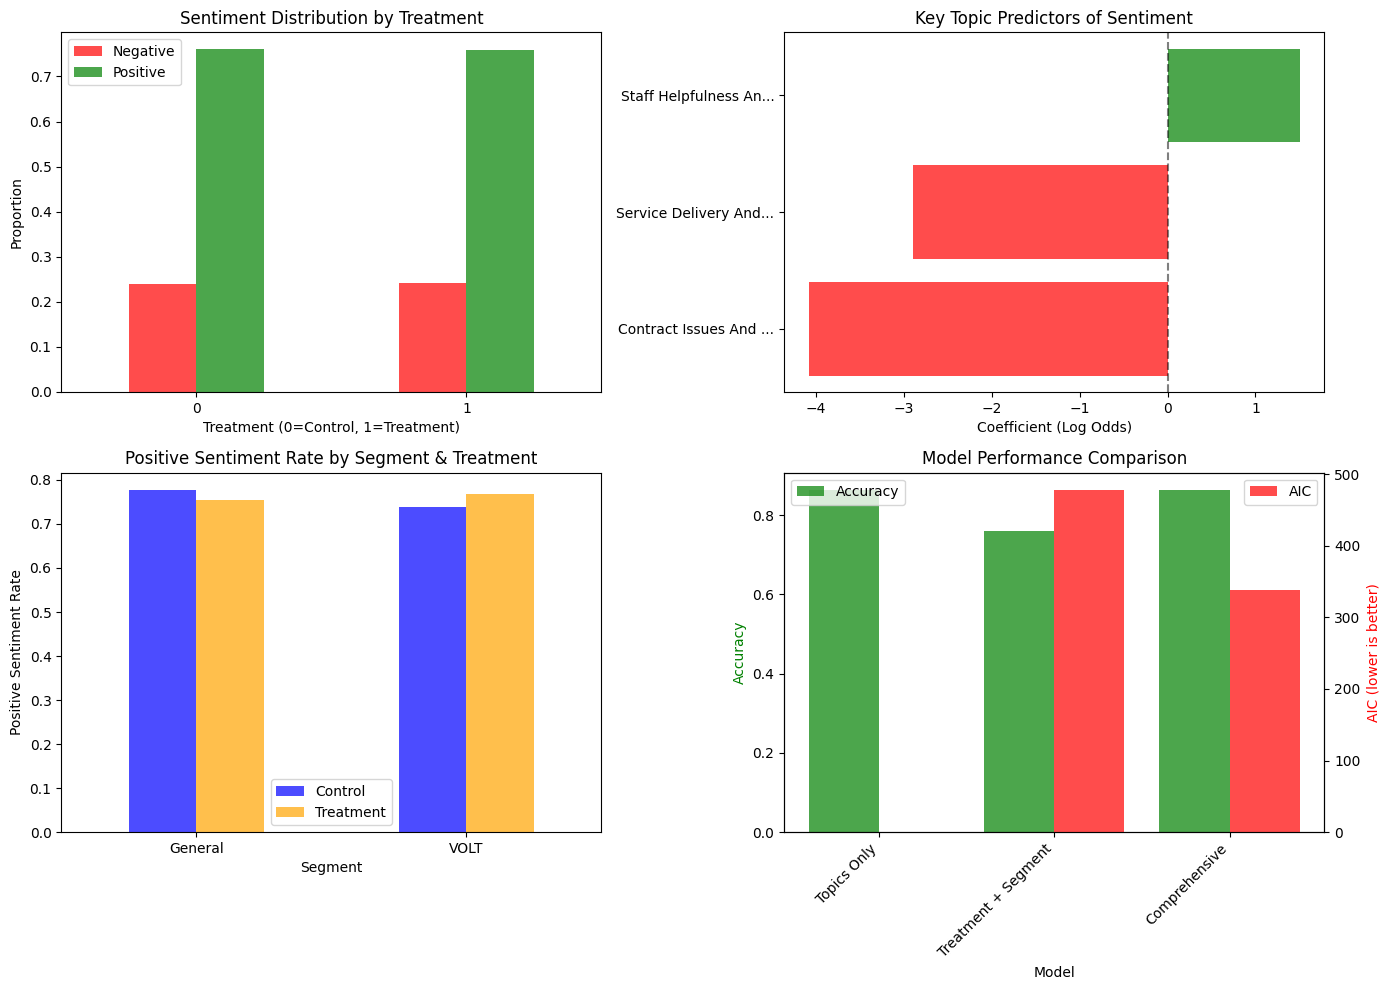


EXECUTIVE SUMMARY - CLASSIFICATION MODEL INSIGHTS
✓ Data: 428 comments, 76% positive sentiment
✓ Model accuracy: 86.4%

🎯 KEY SENTIMENT DRIVERS:
   📉 DECREASES sentiment: Contract Issues And Call Center Problems (OR: 0.02)
   📉 DECREASES sentiment: Service Delivery And Scheduling Issues (OR: 0.06)
   📈 INCREASES sentiment: Staff Helpfulness And Communication (OR: 4.50)

🧪 TREATMENT EFFECT:
   • No significant impact on overall sentiment (p = 0.919)
   • No significant impact on topic usage patterns
   • New script does NOT systematically change emotional tone

📊 MODEL INSIGHTS:
   • Topics are much stronger predictors than treatment assignment
   • Content matters more than script version for sentiment
   • Model explains 30.9% of sentiment variance


In [90]:
# --------------------------------------------------------
# 9) Visualization of key findings
# --------------------------------------------------------
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# 1. Sentiment distribution by treatment
sentiment_by_treatment = df_model.groupby(['TREATMENT_BINARY', 'sentiment_positive']).size().unstack()
sentiment_by_treatment_pct = sentiment_by_treatment.div(sentiment_by_treatment.sum(axis=1), axis=0)
sentiment_by_treatment_pct.plot(kind='bar', ax=ax1, color=['red', 'green'], alpha=0.7)
ax1.set_title('Sentiment Distribution by Treatment')
ax1.set_xlabel('Treatment (0=Control, 1=Treatment)')
ax1.set_ylabel('Proportion')
ax1.legend(['Negative', 'Positive'])
ax1.tick_params(axis='x', rotation=0)

# 2. Key topic effects on sentiment (odds ratios)
if len(significant_predictors) > 0:
    top_predictors = significant_predictors.head(5)
    topic_names = [name.replace('topic_', '').replace('_', ' ').title()[:20] + '...' 
                   if len(name.replace('topic_', '').replace('_', ' ').title()) > 20 
                   else name.replace('topic_', '').replace('_', ' ').title() 
                   for name in top_predictors['topic']]
    
    colors = ['red' if x < 0 else 'green' for x in top_predictors['coefficient']]
    bars = ax2.barh(range(len(topic_names)), top_predictors['coefficient'], color=colors, alpha=0.7)
    ax2.set_yticks(range(len(topic_names)))
    ax2.set_yticklabels(topic_names)
    ax2.set_xlabel('Coefficient (Log Odds)')
    ax2.set_title('Key Topic Predictors of Sentiment')
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# 3. Treatment effect across segments
segment_treatment_sentiment = df_model.groupby(['SEGMENT', 'TREATMENT_BINARY'])['sentiment_positive'].mean().unstack()
segment_treatment_sentiment.plot(kind='bar', ax=ax3, color=['blue', 'orange'], alpha=0.7)
ax3.set_title('Positive Sentiment Rate by Segment & Treatment')
ax3.set_xlabel('Segment')
ax3.set_ylabel('Positive Sentiment Rate')
ax3.legend(['Control', 'Treatment'])
ax3.tick_params(axis='x', rotation=0)

# 4. Model performance comparison
models = ['Topics Only', 'Treatment + Segment', 'Comprehensive']
treatment_pred = (treatment_model.predict() > 0.5).astype(int)
comprehensive_pred = (comprehensive_model.predict() > 0.5).astype(int)
accuracies = [0.864, (treatment_pred == df_model['sentiment_positive']).mean(), 
              (comprehensive_pred == df_model['sentiment_positive']).mean()]
aics = [0, treatment_model.aic, comprehensive_model.aic]

ax4_twin = ax4.twinx()
bars1 = ax4.bar([x-0.2 for x in range(len(models))], accuracies, width=0.4, alpha=0.7, color='green', label='Accuracy')
bars2 = ax4_twin.bar([x+0.2 for x in range(len(models))], aics, width=0.4, alpha=0.7, color='red', label='AIC')

ax4.set_xlabel('Model')
ax4.set_ylabel('Accuracy', color='green')
ax4_twin.set_ylabel('AIC (lower is better)', color='red')
ax4.set_title('Model Performance Comparison')
ax4.set_xticks(range(len(models)))
ax4.set_xticklabels(models, rotation=45, ha='right')

# Add legends
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Summary insights
print("\n" + "="*60)
print("EXECUTIVE SUMMARY - CLASSIFICATION MODEL INSIGHTS")
print("="*60)
print(f"✓ Data: {len(df_model)} comments, {df_model['sentiment_positive'].mean():.0%} positive sentiment")
print(f"✓ Model accuracy: {(comprehensive_pred == df_model['sentiment_positive']).mean():.1%}")
print(f"\n🎯 KEY SENTIMENT DRIVERS:")
for _, row in significant_predictors.iterrows():
    direction = "📈 INCREASES" if row['coefficient'] > 0 else "📉 DECREASES"
    topic_clean = row['topic'].replace('topic_', '').replace('_', ' ').title()
    print(f"   {direction} sentiment: {topic_clean} (OR: {row['odds_ratio']:.2f})")

print(f"\n🧪 TREATMENT EFFECT:")
print(f"   • No significant impact on overall sentiment (p = {treatment_p:.3f})")
print(f"   • No significant impact on topic usage patterns")
print(f"   • New script does NOT systematically change emotional tone")

print(f"\n📊 MODEL INSIGHTS:")
print(f"   • Topics are much stronger predictors than treatment assignment")
print(f"   • Content matters more than script version for sentiment")
print(f"   • Model explains {comprehensive_model.prsquared:.1%} of sentiment variance")